# Generating a Mock Photometric Survey

This notebook generates a realistic photometric survey catalog using a system of galaxy SED templates and photometric filters. A variety of SEDs and filters are also packaged in the repository.

The final product of this notebook is a set of noisy fluxes, redshifts, and galaxy types.

Note that this code requires BPZ 1.99. Various BPZ routines are used, including the type-magnitude-redshift priors. The depth/selection function mimicks that of a real survey thanks to realistic noise and selection models. The likelihood function is also taken from BPZ. However, unlike in BPZ it is properly binned into a coarse resolution.

This notebook is based on a similar notebook written by Boris Leistedt (http://github.com/ixkael).

As always, the first step is to set up the environment!

In [1]:
import sys # system commands
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d # interpolation

import itertools # iteration utilities

bpz_dir = '/Users/Josh/Dropbox/bpz-1.99.3/' # BPZ directory
sys.path.append(bpz_dir)
from prior_hdfn_gen import function as bpz_prior
from bpz_tools import * # loads a bunch of functions from BPZ (note that some of them are weirdly named)

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

# constant
c=2.998e+18 # speed of light in A/s

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Now we want to import our templates, filters, and priors.

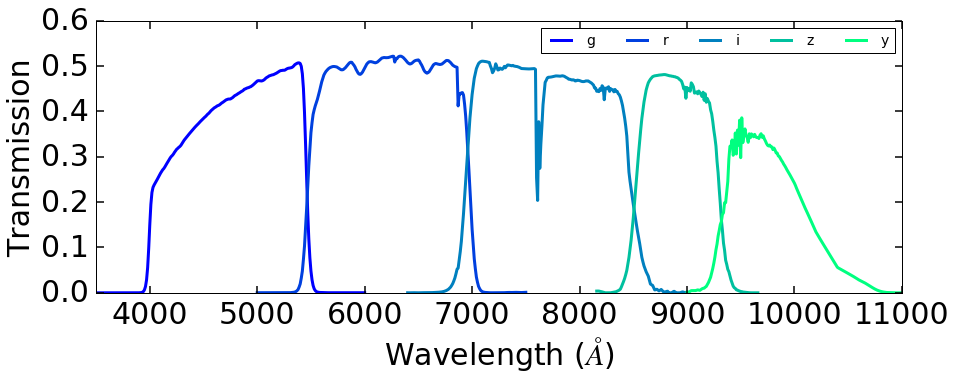

In [2]:
### initialize filter library ###
filters=open('filters/HSC.list') # filter list
fname,ffile=[],[]
for line in filters:
    temp=line.strip().split()
    fname.append(temp[0]) # name
    ffile.append(temp[1]) # filename
filters.close()
Nf=len(fname) # total number of filters
fw,fn,ft=[],[],[]
for i in ffile:
    data=loadtxt('filters/'+i)
    fw.append(data[:,0]) # wavelength (A)
    fn.append(c/data[:,0]) # frequency (Hz)
    ft.append(data[:,1]) # transmission
    
# plotting
fcolors=get_cmap('winter')(linspace(0,1,Nf)) # filter colors
xlow,xhigh=min(list(flatten(fw))),max(list(flatten(fw)))
figure(figsize=(14,6))
for i in xrange(Nf):
    plot(fw[i],ft[i],lw=3,color=fcolors[i],label=fname[i])
xlim([xlow,xhigh])
xlabel(r'Wavelength ($\AA$)')
ylabel('Transmission')
legend(ncol=Nf,fontsize=14)
tight_layout()

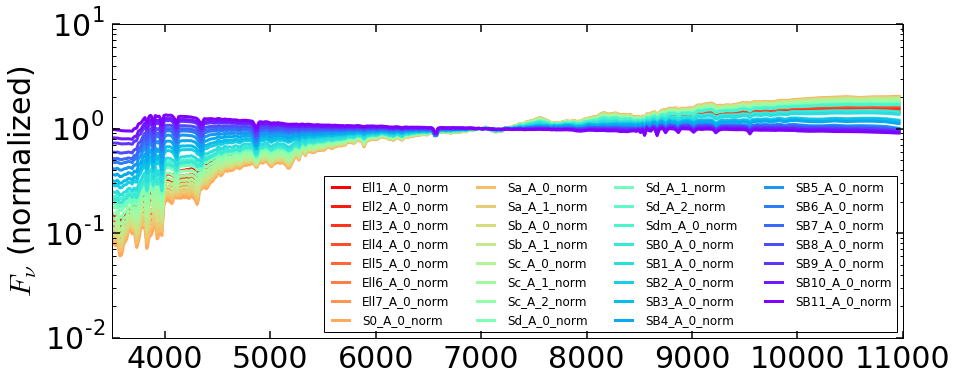

In [3]:
### initialize template library ###
templates=open('seds/COSMOS_MOD.list') # template list
ttype,tfile=[],[]
for line in templates:
    temp=line.strip().split()[1:]
    ttype.append(temp[0]) # type
    tfile.append(temp[1]) # filename
templates.close()
tname=[i.replace('.sed','') for i in tfile]
Nt=len(ttype) # total number of templates
ttypes,Ntypes=unique(ttype,return_counts=True) # types and numbers
ttypes,Ntypes=ttypes[[0,2,1]],Ntypes[[0,2,1]] # rearrange for PGAL/SGAL/SB
tw,tfl,tfn=[],[],[]
for i in tfile:
    data=loadtxt('seds/'+i)
    tw.append(data[:,0]) # Template wavelength (A)
    tfl.append(data[:,1]) # Template F_lambda (per A)
    tfn.append(data[:,1]*data[:,0]**2) # Template F_nu (per nu)
    
# plotting 
tcolors=get_cmap('rainbow_r')(linspace(0,1,Nt)) # template colors
figure(figsize=(14,6))
for i in xrange(Nt):
    sel=(tw[i]>xlow)&(tw[i]<xhigh)
    wavelength,flux=tw[i][sel],tfn[i][sel]
    semilogy(wavelength,flux/interp(7e3,wavelength,flux),lw=3,color=tcolors[i],label=tname[i])
xlim([xlow,xhigh])
ylabel(r'$F_{\nu}$ (normalized)')
legend(ncol=4,fontsize=12,loc=4)
tight_layout()

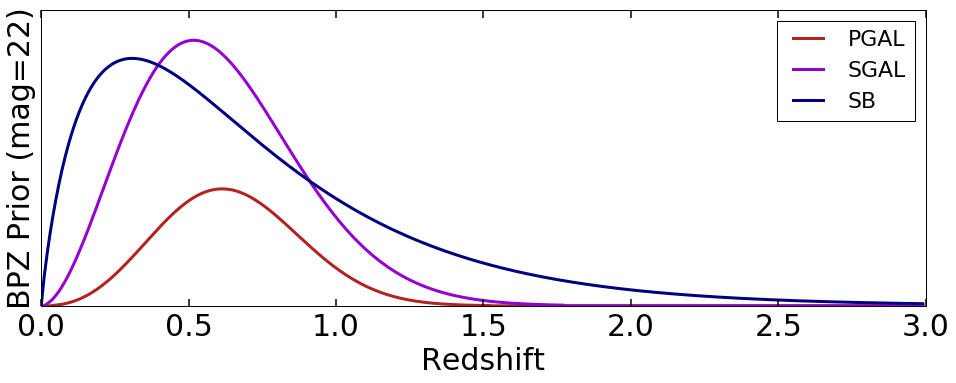

In [4]:
### import BPZ prior, i.e. p(z,m,t) distributions ###
dz=0.01 # dz
z_low,z_high=0.0,3.0 # low/high bounds
z_grid = np.arange(z_low,z_high,dz) # grid
mag=22.0 # reference magnitude
p_ztm=bpz_prior(z_grid,mag,(1,1,1)) # p(z,m,t) evaluated over grid

# plotting
pcolors=['firebrick','darkviolet','navy'] # prior colors
figure(figsize=(14,6))
for i in xrange(len(Ntypes)):
    plot(z_grid,p_ztm[:,i],lw=3,color=pcolors[i],label=ttypes[i])
xlabel('Redshift')
ylabel('BPZ Prior (mag=22)')
yticks([])
legend(fontsize=22)
tight_layout()

Now that we have intialized our filters, templates, and priors, we need to formulate our population/survey priors.

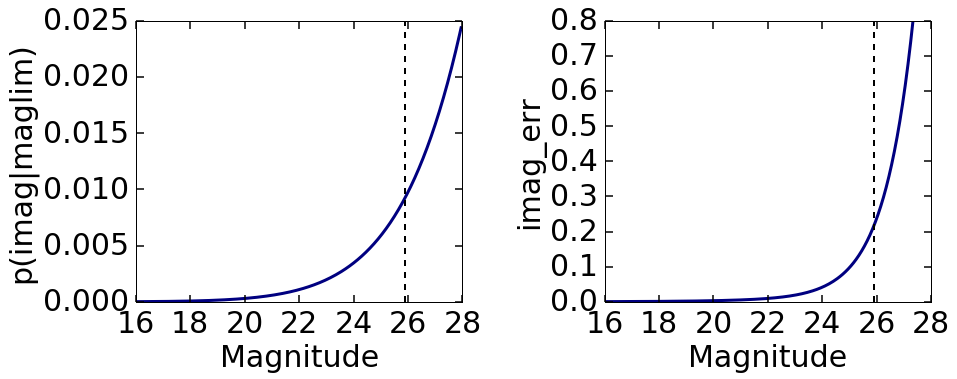

In [6]:
maglims=[26.5,26.1,25.9,25.1,24.4] # g,r,i,z,y
maglim=maglims[2]  # i-band magnitude limit
off=1.  # some offset
imag_grid=arange(16,28,0.05)  # grid for i magnitude

# some parameters for p(imag)
alpha=15.0 
beta=2

# p(imag) distribution
p_imag = imag_grid**alpha*exp(-(imag_grid/(maglim-off))**beta)
p_imag /= p_imag.sum()

# imag error distribution as function of mag limit, as in Rykoff et al.
def mag_err(m, mlim):
    a,b=4.56,1
    k=1
    sigmadet=5
    teff=exp(a+b*(mlim-21.))
    F=10**(-0.4*(m-22.5))
    Flim=10**(-0.4*(mlim-22.5))
    Fnoise=(Flim/sigmadet)**2*k*teff-Flim
    return 2.5/log(10)*sqrt((1+Fnoise/F)/(F*k*teff))

# plotting
figure(figsize=(14,6))
subplot(1,2,1)
plot(imag_grid,p_imag,lw=3,color='navy')
axvline(maglim,ls='--',lw=2,color='k')
xlabel('Magnitude')
ylabel('p(imag|maglim)')
tight_layout()
subplot(1,2,2)
plot(imag_grid,mag_err(imag_grid, maglim),lw=3,color='navy')
axvline(maglim,ls='--',lw=2,color='k')
xlabel('Magnitude')
ylabel('imag_err')
ylim([0, 0.8])
tight_layout()

Now we can sample objects from our survey!

In [7]:
# Draw i-band magnitudes from a gridded prob(imag)
def draw_mag(Nobj,imag_grid,p_imag):
    func=interp1d(append(0,p_imag.cumsum()),append(imag_grid[0]-1e-2,imag_grid),'linear') # inverse CDF
    return func(rand(Nobj))
    
# Draw templates+redshifts for given z_grid, imag, and which types are used. 
def draw_types_and_redshifts(nobj,z_grid,imags,Ntypes):
    types = np.zeros(nobj, dtype=int) # types
    redshifts = np.zeros(nobj, dtype=float) # redshifts
    type_idx=append(0,cumsum(Ntypes))
    for i in range(nobj):
        if i%10000==0: sys.stdout.write(str(i)+' ')
        p_ztm=bpz_prior(z_grid,imags[i],(1,1,1)) # sample (z,t|m) prior
        galtype=choice([0,1,2],p=p_ztm.sum(axis=0)/p_ztm.sum()) # select galaxy type
        types[i]=randint(type_idx[galtype],type_idx[galtype+1]) # select template (t|m)
        func=interp1d(p_ztm[:,0].cumsum()/p_ztm[:,0].sum(),z_grid,'linear') # inverse CDF
        redshifts[i]=func(uniform()) # select redshift (z|t,m)
    return redshifts, types

In [8]:
Nobj=500000 # number of objects
imags=draw_mag(Nobj,imag_grid,p_imag) # draw i-band magnitudes
redshifts,types=draw_types_and_redshifts(Nobj,z_grid,imags,Ntypes)

0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 220000 230000 240000 250000 260000 270000 280000 290000 300000 310000 320000 330000 340000 350000 360000 370000 380000 390000 400000 410000 420000 430000 440000 450000 460000 470000 480000 490000 

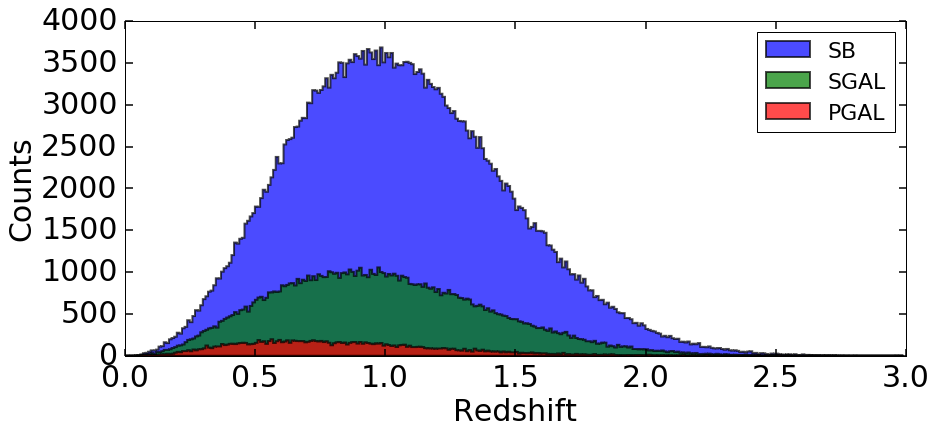

In [9]:
# plotting
figure(figsize=(14,6))
h=hist(redshifts[array(ttype)[types]==ttypes[-1]],z_grid,histtype='stepfilled',lw=2,alpha=0.7,label=ttypes[-1])
h=hist(redshifts[array(ttype)[types]==ttypes[-2]],z_grid,histtype='stepfilled',lw=2,alpha=0.7,label=ttypes[-2])
h=hist(redshifts[array(ttype)[types]==ttypes[-3]],z_grid,histtype='stepfilled',lw=2,alpha=0.7,label=ttypes[-3])
legend(fontsize=22)
xlabel('Redshift')
ylabel('Counts')

Given our new catalog of templates, we now need to generate fluxes.

In [10]:
### applies IGM extinction (per Madau et al.) to input spectrum at redshift z over input wavelength grid ###

# subroutine for component 1
def mteff1(wave,z,l,coeff):
    zlambda=l*(1+z) # redshifted line wavelength
    temp=zeros(wave.shape)
    sel=(wave<zlambda) # selecting all wavelengths < zlambda
    temp[sel]+=coeff*(wave[sel]/l)**3.46 # applying extinction
    return temp

# Component 1: Lyman-alpha to the Lyman limit
def madau_teff1(wave,z): # 912-1216 A
    teff1=zeros(wave.shape)
    teff1+=mteff1(wave,z,1216.0,0.0037) # 2->1
    teff1+=mteff1(wave,z,1026.0,0.00177) # 3->1
    teff1+=mteff1(wave,z,973.0,0.00106) # 4->1
    teff1+=mteff1(wave,z,950.0,0.000584) # 5->1
    teff1+=mteff1(wave,z,938.1,0.00044) # 6->1
    teff1+=mteff1(wave,z,931.0,0.00040) # 7->1
    teff1+=mteff1(wave,z,926.5,0.00037) # 8->1
    teff1+=mteff1(wave,z,923.4,0.00035) # 9->1
    teff1+=mteff1(wave,z,921.2,0.00033) # 10->1
    teff1+=mteff1(wave,z,919.6,0.00032) # 11->1
    teff1+=mteff1(wave,z,918.4,0.00031) # 12->1
    return teff1

# Component 2: Past the Lyman limit
def madau_teff2(wave,z): # < 912 A
    zlambda=912.0*(1+z) # redshifted boundary
    teff2=zeros(wave.shape)
    sel=(wave<zlambda) # selecting all lambda < 912
    xc=wave[sel]/912.0 # the (1+z) factors assuming this was at rest-frame 912 A
    xem=zeros(sel.sum())+(1+z) # observed (1+z) factors
    temp=0.25*(xc**3)*(xem**0.46-xc**0.46) # component 1
    temp+=9.4*(xc**1.5)*(xem**0.18-xc**0.18) # component 2
    temp-=0.7*(xc**3)*(xc**-1.32-xem**-1.32) # component 3
    temp-=0.023*(xem**1.68-xc**1.68) # component 4
    teff2[sel]+=temp
    teff2[teff2<0.]=0.
    return teff2

# final function
def madau_teff(wave,z):
    tf=madau_teff1(wave,z)+madau_teff2(wave,z) # adds together 912-1216 (teff1) and <912 (teff2) portions for optical depth
    teff=exp(-tf) # convert from optical depth to effective transmission
    return teff

In [11]:
phot=zeros((Nobj,Nf))
tlw=[log(tw[i]) for i in xrange(Nt)]
flw=[log(fw[i]) for i in xrange(Nf)]
norm=[trapz(ft[i]/fn[i],fn[i]) for i in xrange(Nf)]

for i in xrange(Nobj):
    if i%5000==0: sys.stdout.write(str(i)+' ')
    z,t=redshifts[i],types[i]
    tfn_z=madau_teff((1+z)*tw[t],z)*tfn[t]
    func=interp1d(tlw[t]+log(1+z),arcsinh(tfn_z),'linear')
    phot[i]=[trapz(sinh(func(flw[j]))*ft[j]/fn[j],fn[j])/norm[j] for j in xrange(Nf)]

0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 155000 160000 165000 170000 175000 180000 185000 190000 195000 200000 205000 210000 215000 220000 225000 230000 235000 240000 245000 250000 255000 260000 265000 270000 275000 280000 285000 290000 295000 300000 305000 310000 315000 320000 325000 330000 335000 340000 345000 350000 355000 360000 365000 370000 375000 380000 385000 390000 395000 400000 405000 410000 415000 420000 425000 430000 435000 440000 445000 450000 455000 460000 465000 470000 475000 480000 485000 490000 495000 

These fluxes are unnnormalized, so we now normalize all results to the AB mag=23.9 zero-point in the i-band. We then add in errors for each band depending on the imaging depth.

In [12]:
phot/=phot[:,2][:,None] # normalize to i-band
mags=-2.5*log10(phot)+imags[:,None] # convert to magnitudes
magerrs=array([mag_err(mags[:,i],maglims[i]) for i in xrange(Nf)]).T # compute mag errs
fluxes=10**(-0.4*(mags-23.9)) # convert to fluxes
fluxerrs=log(10)/2.5*magerrs*fluxes # compute flux errors
fluxes_meas=fluxes+fluxerrs*randn(Nobj,Nf) # sample measured flux
mags_meas=-2.5*log10(fluxes_meas)+23.9 # convert to magnitudes

C:\Users\Josh\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: RuntimeWarning: invalid value encountered in log10


Now let's apply selection effects to our catalog. We'll assume an object is only selected if it's detected at >5-sigma in the i-band.

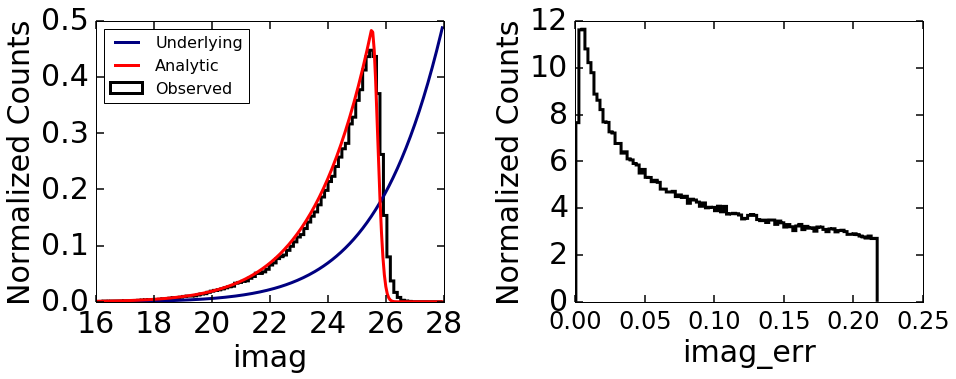

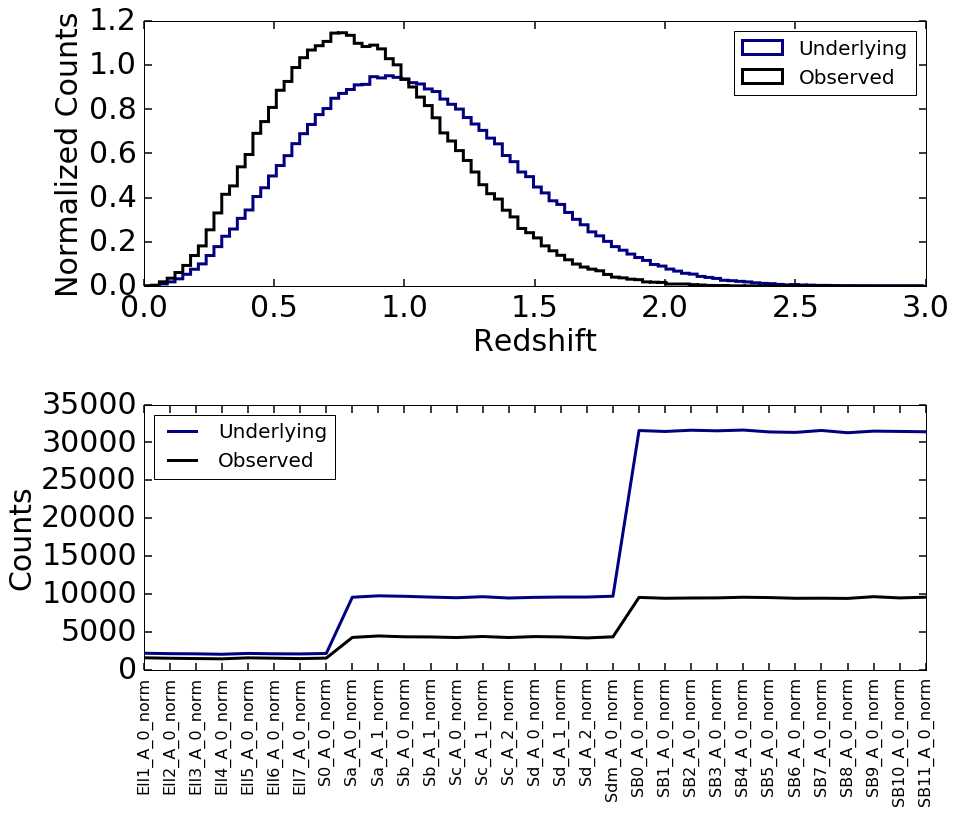

In [13]:
sel=((fluxes/fluxerrs)[:,2]>5.) # applying SNR cut
Nsel = sel.sum() # number of galaxies post-cut
counts=[sum(types==i) for i in xrange(Nt)] # number of individual templates
counts_sel=[sum(types[sel]==i) for i in xrange(Nt)]

# analytic prediction
detprob=copy(p_imag) 
ind=(imag_grid>=maglim-0.4)
detprob[ind]*=exp(-0.5*((imag_grid[ind]-maglim+0.4)/0.2)**2)
detprob/=trapz(detprob,imag_grid)

# plotting
figure(figsize=(14,6))
subplot(1,2,1)
plot(imag_grid,p_imag/p_imag.sum()/(imag_grid[1]-imag_grid[0]),lw=3,color='navy',label='Underlying')
plot(imag_grid,detprob,lw=3,color='red',label='Analytic')
hist(mags_meas[:,2][sel],range=[imag_grid.min(),imag_grid.max()],bins=100,
     histtype='step',lw=3,normed=True,color='black',label='Observed')
legend(loc=2,fontsize=16)
xlabel('imag')
ylabel('Normalized Counts')
tight_layout()
subplot(1,2,2)
hist(magerrs[:,2][sel],normed=True,bins=100,histtype='step',lw=3,color='black')
xticks(fontsize=24)
xlabel('imag_err')
ylabel('Normalized Counts')
tight_layout()

figure(figsize=(14,12))
subplot(2,1,1)
hist(redshifts,normed=True,range=[z_grid.min(),z_grid.max()],bins=100,histtype='step',lw=3,color='navy',label='Underlying')
hist(redshifts[sel],normed=True,range=[z_grid.min(),z_grid.max()],bins=100,histtype='step',lw=3,color='black',label='Observed')
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('Normalized Counts')
subplot(2,1,2)
plot(counts,color='navy',lw=3,label='Underlying')
plot(counts_sel,color='black',lw=3,label='Observed')
xticks(arange(Nt),tname,rotation=90,fontsize=16)
ylabel('Counts')
legend(loc=2,fontsize=20)
tight_layout()

C:\Users\Josh\Anaconda\lib\site-packages\numpy\lib\function_base.py:229: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\Josh\Anaconda\lib\site-packages\numpy\lib\function_base.py:230: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


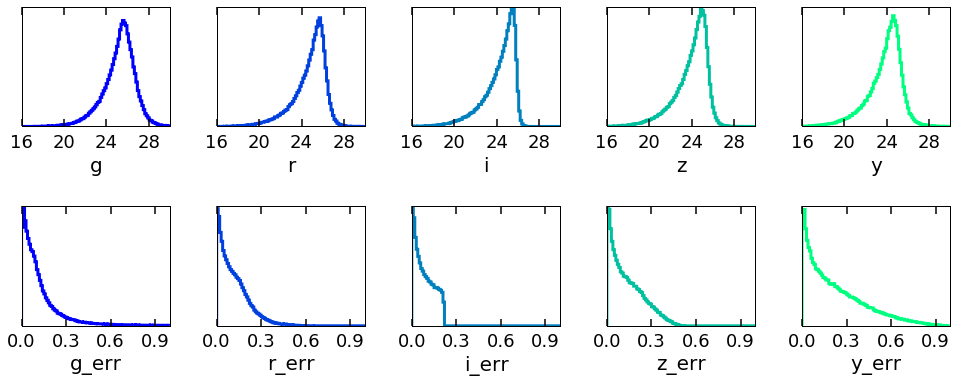

In [14]:
# plotting flux distribution
figure(figsize=(14,6))
for i in xrange(Nf):
    subplot(2,Nf,i+1)
    hist(mags_meas[:,i][sel],normed=True,range=[16,30],bins=100,histtype='step',lw=3,color=fcolors[i])
    yticks([])
    xticks(arange(16,30,4),fontsize=18)
    xlabel(fname[i],fontsize=20)
    tight_layout()
    subplot(2,Nf,i+1+Nf)
    hist(magerrs[:,i][sel],normed=True,range=[0,1],bins=100,histtype='step',lw=3,color=fcolors[i])
    xticks(arange(0,1,0.3),fontsize=18)
    xlabel(fname[i]+'_err',fontsize=20)
    yticks([])
    tight_layout()

Let's also see how we've sampled from the intrinsic color-redshift relation for each template.

In [15]:
# construct color-redshift tracts
phot_tz = zeros((Nt,len(z_grid),Nf)) # template photometry as a function of redshift

for t in xrange(Nt):
    for i in xrange(len(z_grid)):
        z=z_grid[i]
        tfn_z=madau_teff((1+z)*tw[t],z)*tfn[t]
        func=interp1d(tlw[t]+log(1+z),arcsinh(tfn_z),'linear')
        phot_tz[t][i]=[trapz(sinh(func(flw[j]))*ft[j]/fn[j],fn[j])/norm[j] for j in xrange(Nf)]

C:\Users\Josh\Anaconda\lib\site-packages\IPython\kernel\__main__.py:8: RuntimeWarning: invalid value encountered in log10
C:\Users\Josh\Anaconda\lib\site-packages\IPython\kernel\__main__.py:9: RuntimeWarning: invalid value encountered in log10


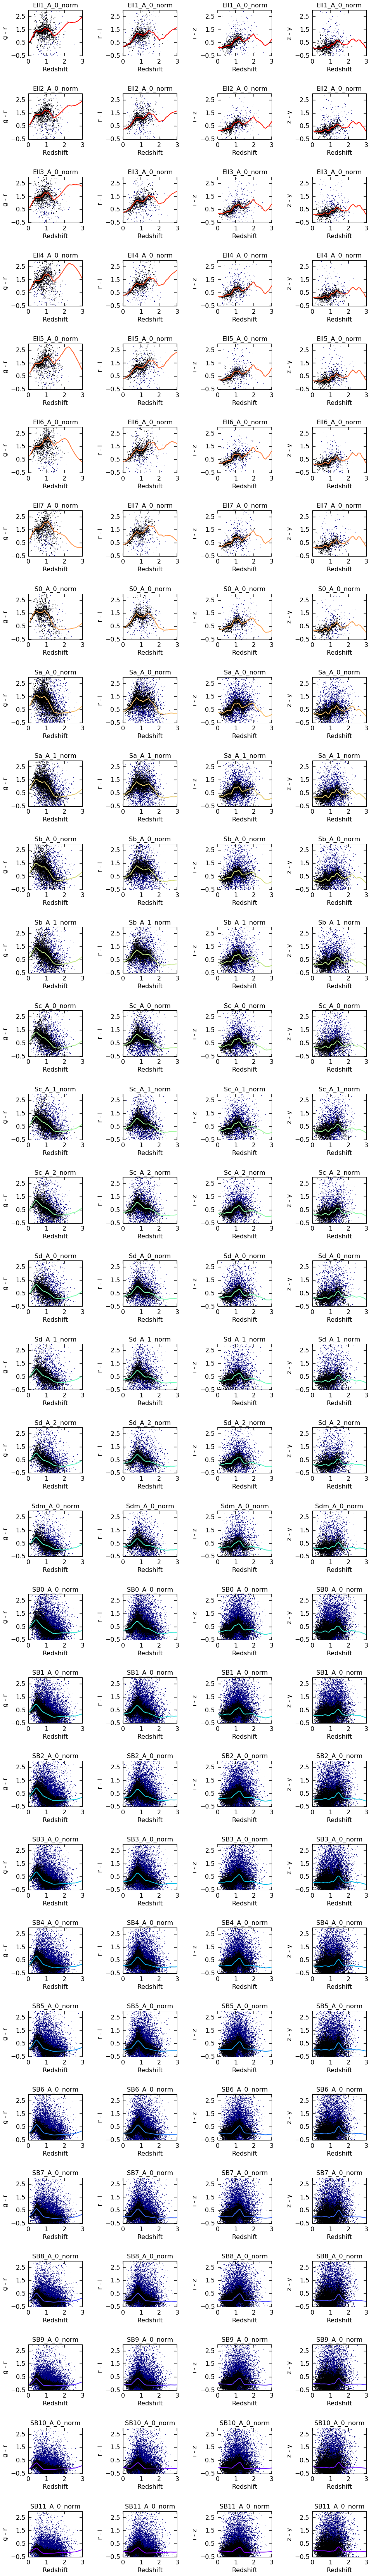

In [16]:
# plotting

figure(figsize=(14,3*Nt))
for i in xrange(Nt):
    for j in xrange(Nf-1):
        subplot(Nt,Nf-1,j+1+i*(Nf-1))
        tsel=(types==i)
        plot(redshifts[tsel],-2.5*log10(fluxes_meas[:,j]/fluxes_meas[:,j+1])[tsel],'.',markersize=1.5,color='navy')
        plot(redshifts[tsel&sel],-2.5*log10(fluxes_meas[:,j]/fluxes_meas[:,j+1])[tsel&sel],'.',markersize=2.5,color='black')
        plot(z_grid,-2.5*log10(phot_tz[i][:,j]/phot_tz[i][:,j+1]),color=tcolors[i],lw=2)
        xticks(linspace(0,3,4),fontsize=16)
        xlabel('Redshift',fontsize=16)
        ylim([-0.5,3])
        yticks(linspace(-0.5,2.5,4),fontsize=16)
        ylabel(fname[j]+' - '+fname[j+1],fontsize=16)
        title(tname[i],y=1.02,fontsize=16)
        tight_layout()

Finally, we just dump our catalogs to disk.

In [17]:
save('mock_catalog_hsc-cosmos',c_[fluxes_meas,fluxerrs,redshifts,types])
save('model_catalog_hsc-cosmos',phot_tz)